In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import pandas as pd
import datetime
import copy

In [2]:
iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{statsdir}/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'
sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'
sonde_file = f'{statsdir}/interpsonde_parameters_celltrack_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'
figdir_jointhist = f'{figdir}jointhist/'
os.makedirs(figdir, exist_ok=True)
os.makedirs(figdir_jointhist, exist_ok=True)

In [3]:
xr.set_options(display_style='text')

In [4]:
# Read sonde data
sonde = xr.open_dataset(sonde_file)
sonde.dims['tracks']

6895

In [5]:
# Read 2D track data
stats2d = xr.open_dataset(stats_file)
time_res = stats2d.attrs['time_resolution_hour']
pixel_radius = stats2d.attrs['pixel_radius_km']
stats2d.dims['tracks']

6895

In [6]:
# Read satellite data
sat = xr.open_dataset(sat_file, drop_variables=['basetime', 'cell_area'])
sat.dims['tracks']

6895

In [7]:
# Combine datasets by coordinates
stats = xr.combine_by_coords([stats2d, sat, sonde], combine_attrs='override')
stats.load()
print(stats)

<xarray.Dataset>
Dimensions:                      (reltime: 4, times: 60, tracks: 6895)
Coordinates:
  * tracks                       (tracks) int32 0 1 2 3 ... 6891 6892 6893 6894
  * reltime                      (reltime) int32 0 -1 -2 -3
  * times                        (times) int32 0 1 2 3 4 5 ... 54 55 56 57 58 59
Data variables: (12/285)
    time                         (tracks, reltime) datetime64[ns] 2018-10-16T...
    tallenough_sfc               (tracks, reltime) float32 1.0 1.0 ... 1.0 1.0
    CAPE_sfc                     (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_sfc                   (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_fract_sfc             (tracks, reltime) float32 nan nan ... nan nan
    CIN_IB_sfc                   (tracks, reltime) float32 -9.999e+03 ... -9....
    ...                           ...
    end_merge_timeindex          (tracks) float64 nan nan nan ... 1.0 nan nan
    end_merge_cloudnumber        (tracks) float64 nan nan n

In [8]:
tracks = stats['tracks']
times = stats['times']

lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

maxdbz = stats['maxdbz']
eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

ctt = stats['cloud_top_temperature_min'] - 273.15
cth = stats['cloud_top_height_max']

In [9]:
stats.sizes

Frozen(SortedKeysDict({'tracks': 6895, 'reltime': 4, 'times': 60}))

In [10]:
tracks = stats['tracks']
times = stats['times']
# height = stats['z'] / 1000.
# time_res = stats.attrs['time_resolution_hour']
# pixel_radius = stats.attrs['pixel_radius_km']
print(f'Number of total tracks: {len(tracks)}')

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

# Subset tracks for the entire dataset
stats = stats.isel(tracks=ind)
stats.dims['tracks']

Number of total tracks: 6895
Number of valid tracks: 6887


6887

In [11]:
lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

In [12]:
# Choose 0 hour relative time, and filter negative parcel values
cape = stats['CAPE_mu'].where(stats['CAPE_mu'] > 0).sel(reltime=0)
cin = stats['CIN_IB_mu'].where(stats['CIN_IB_mu'] >= 0).sel(reltime=0)
lcl_z = stats['LCL_height_mu'].where(stats['LCL_height_mu'] >= 0).sel(reltime=0) / 1000
lfc_z = stats['LFC_height_mu'].where(stats['LFC_height_mu'] >= 0).sel(reltime=0) / 1000
lnb_z = stats['EL_height_mu'].where(stats['EL_height_mu'] >= 0).sel(reltime=0) / 1000
lpl_z = stats['initial_ht_parcel_mu'].where(stats['initial_ht_parcel_mu'] >= 0).sel(reltime=0) / 1000
q850p = stats['rvap_850mb'].sel(reltime=0)
q700p = stats['rvap_700mb'].sel(reltime=0)
rh700p = stats['rh_700mb'].sel(reltime=0)
rh500p = stats['rh_500mb'].sel(reltime=0)
shear6mag = stats['shear_mag_bulk_0to6km'].sel(reltime=0)
shear3mag = stats['shear_mag_bulk_0to3km'].sel(reltime=0)
u700p = stats['U_700mb'].sel(reltime=0)
v700p = stats['V_700mb'].sel(reltime=0)
u850p = stats['U_850mb'].sel(reltime=0)
v850p = stats['V_850mb'].sel(reltime=0)

In [13]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get track start/end hour
# start_hour = start_time.dt.hour
# end_hour = end_time.dt.hour
start_month = start_time.dt.month

In [14]:
# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

# nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
# nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
# ntracks_nonsplit_in = len(nonsplit_in)
# ntracks_nonmerge_in = len(nonmerge_in)
# print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
# print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 5284
Number of non-split tracks: 5359
Number of merge tracks: 1603
Number of split tracks: 1528


In [15]:
# Calculate lifetime max
cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_area_max = cell_area.max(dim='times')
cell_eth20_max = eth20.max(dim='times')
cell_ctt_min = ctt.min(dim='times')
cell_maxdbz_max = maxdbz.max(dim='times')

In [16]:
start_month

<xarray.DataArray 'month' (tracks: 6887)>
array([10, 10, 10, ...,  2,  2,  3])
Coordinates:
  * tracks   (tracks) int32 0 1 2 3 4 5 6 ... 6888 6889 6890 6891 6892 6893 6894

In [17]:
# def histogram_map(x, bins, density=False):
#     hist_x, tmp = np.histogram(x, bins=bins, density=density)
#     return hist_x

# def histogram_map(x, density=False):
#     hist_x, bins = np.histogram(x, density=density)
#     return hist_x

In [18]:
bins_month = [1,3,10,11,12,13]
ncells_month = cell_area_max.groupby_bins(start_month, bins_month, right=False).count()
ncells_month

<xarray.DataArray 'cell_area' (month_bins: 5)>
array([ 748,    1, 1455, 3022, 1661])
Coordinates:
  * month_bins  (month_bins) object [1, 3) [3, 10) [10, 11) [11, 12) [12, 13)

In [19]:
# bins_cellarea = np.arange(0.6, 3.61, 0.1)
# np.log10(cell_area_max).plot.hist(bins=bins_cellarea)

In [20]:
# np.log10(cell_area_max).where(start_month == 10, drop=True).plot.hist(bins=bins_cellarea, density=True, alpha=0.3)
# np.log10(cell_area_max).where(start_month == 11, drop=True).plot.hist(bins=bins_cellarea, density=True, alpha=0.3)
# np.log10(cell_area_max).where(start_month == 12, drop=True).plot.hist(bins=bins_cellarea, density=True, alpha=0.3)
# np.log10(cell_area_max).where((start_month >= 1) & (start_month <= 3), drop=True).plot.hist(bins=bins_cellarea, density=True, alpha=0.3)

In [21]:
# min_ns = 100
# bins_month = [1,3,10,11,12,13]

# # Count the number of samples in each month bin
# ncells_month = cell_area_max.groupby_bins(start_month, bins_month, right=False).count()

# bins_cellarea = np.arange(0.6, 3.61, 0.1)

# binv_month = [1,10,11,12]
# binv_cellarea = bins_cellarea[:-1] + np.diff(bins_cellarea)/2

# pdf_cellareamax_month = np.full((nmonths, len(bins_cellarea)-1), 0, dtype=float)

# binv_month = []
# for ii in range(nmonths-1):
#     if (ncells_month[ii] > min_ns):
#         binv_month.append(bins_month[ii])
#         pdf_cellareamax_month[ii,:], bins = np.histogram(np.log10(cell_area_max).where((start_month >= bins_month[ii]) & 
#                                                    (start_month < bins_month[ii+1]), drop=True), bins=bins_cellarea, density=True)
# # hist_x.shape, bins_cellarea.shape

# idx = np.where(ncells_month > min_ns)[0]
# pdf_cellareamax_month = pdf_cellareamax_month[idx,:]

In [22]:
def hist_bymonth(data_array, data_month, bins_data, bins_month, nsample_month, min_ns):
    # Bin center values
    binv_data = bins_data[:-1] + np.diff(bins_data)/2
    nmonths = len(bins_month)
    pdf_month = np.full((nmonths, len(bins_data)-1), 0, dtype=float)

    binv_month = []
    for ii in range(nmonths-1):
        # Constrain by min sample size
        if (nsample_month[ii] > min_ns):
            binv_month.append(bins_month[ii])
            pdf_month[ii,:], bins = np.histogram(
                data_array.where(
                    (data_month >= bins_month[ii]) & 
                    (data_month < bins_month[ii+1]), drop=True), 
                bins=bins_data, density=True)

    # Keep months exceeding min sample size
    idx = np.where(nsample_month > min_ns)[0]
    pdf_month = pdf_month[idx,:]
    
    return (pdf_month, binv_data)

In [23]:
min_ns = 100
bins_month = [1,3,10,11,12,13]

# Count the number of samples in each month bin
ncells_month = cell_area_max.groupby_bins(start_month, bins_month, right=False).count()
# Get the months where the sample number exceeds the min threshold
binv_month = np.array(bins_month[:-1])[ncells_month.values > min_ns]

bins_cellarea = np.arange(0.6, 3.61, 0.1)
bins_maxdbz = np.arange(10, 75.1, 5)
bins_ctt = np.arange(-100, 20.1, 5)
bins_eth20 = np.arange(0, 21.1, 1)

pdf_cellareamax_month, binv_cellarea = hist_bymonth(np.log10(cell_area_max), start_month, bins_cellarea, bins_month, ncells_month, min_ns)
pdf_maxdbz_month, binv_maxdbz = hist_bymonth(cell_maxdbz_max, start_month, bins_maxdbz, bins_month, ncells_month, min_ns)
pdf_minctt_month, binv_minctt = hist_bymonth(cell_ctt_min, start_month, bins_ctt, bins_month, ncells_month, min_ns)
pdf_maxeth20_month, binv_eth20 = hist_bymonth(cell_eth20_max, start_month, bins_eth20, bins_month, ncells_month, min_ns)

In [66]:
bins_cape = np.arange(0,6000.1,200)
bins_lnb = np.arange(0,17.1,1)
bins_lpl = np.arange(0, 1.81, 0.2)
bins_q850p = np.arange(4,19.1,0.5)
bins_rh500p = np.arange(0, 100.1, 10)
bins_shear6mag = np.arange(6,50.1,2)

pdf_cape_month, binv_cape = hist_bymonth(cape, start_month, bins_cape, bins_month, ncells_month, min_ns)
pdf_lnb_month, binv_lnb = hist_bymonth(lnb_z, start_month, bins_lnb, bins_month, ncells_month, min_ns)
pdf_lpl_month, binv_lpl = hist_bymonth(lpl_z, start_month, bins_lpl, bins_month, ncells_month, min_ns)
pdf_q850p_month, binv_q850p = hist_bymonth(q850p, start_month, bins_q850p, bins_month, ncells_month, min_ns)
pdf_rh500p_month, binv_rh500p = hist_bymonth(rh500p, start_month, bins_rh500p, bins_month, ncells_month, min_ns)
pdf_shear6mag_month, binv_shear6mag = hist_bymonth(shear6mag, start_month, bins_shear6mag, bins_month, ncells_month, min_ns)

(array([160., 535., 466., 436., 360., 263., 350., 452., 380., 477., 565.,
        518., 471., 274., 246., 291., 192., 212., 152.,  87.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

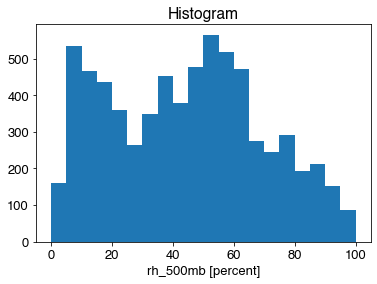

In [58]:
# bins_shear6mag = np.arange(6,50.1,2)
# bins_lpl = np.arange(0, 1.81, 0.1)
# lpl_z.plot.hist(bins=bins_lpl)

bins_rh500p = np.arange(0, 100.1, 5)
rh500p.plot.hist(bins=bins_rh500p)

In [24]:
binv_month

array([ 1, 10, 11, 12])

In [25]:
# bins_eth20 = np.arange(0, 20.1, 0.5)
# # cell_ctt_min.plot.hist(bins=bins_ctt)
# cell_eth20_max.plot.hist(bins=bins_eth20)

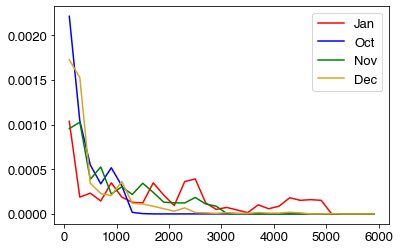

In [34]:
month_names = {1:'Jan', 10:'Oct', 11:'Nov', 12:'Dec'}
colors = {1:'r', 10:'b', 11:'g', 12:'goldenrod'}
for ii in range(len(colors)):
    # plt.plot(binv_cellarea, pdf_cellareamax_month[ii,:], color=colors[list(colors.keys())[ii]], label=list(month_names.values())[ii])
    # plt.plot(binv_maxdbz, pdf_maxdbz_month[ii,:], color=colors[list(colors.keys())[ii]], label=list(month_names.values())[ii])
    # plt.plot(binv_minctt, pdf_minctt_month[ii,:], color=colors[list(colors.keys())[ii]], label=list(month_names.values())[ii])
    # plt.plot(binv_eth20, pdf_maxeth20_month[ii,:], color=colors[list(colors.keys())[ii]], label=list(month_names.values())[ii])
    plt.plot(binv_cape, pdf_cape_month[ii,:], color=colors[list(colors.keys())[ii]], label=list(month_names.values())[ii])
plt.legend()
# list(colors.keys())[0]

In [50]:
def plot_2x2(xbins, hist, xlabels, titles, figname):

    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=100)
    
    month_names = {1:'Jan-Feb', 10:'Oct', 11:'Nov', 12:'Dec'}
    colors = {1:'r', 10:'b', 11:'g', 12:'goldenrod'}
    
    for row in range(2):
        for col in range(2):
            ax = axes[row, col]
            for ii in range(len(colors)):
                l1 = ax.plot(xbins[row][col], hist[row][col][ii,:], lw=2, 
                             color=colors[list(colors.keys())[ii]], label=list(month_names.values())[ii])
            ax.grid(ls='--')
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel('Frequency')
            ax.set_title(titles[row][col], loc='left')
            # ax.set_xticks(xticks[row][col])
            # ax.set_yticks(yticks[row][col])
            if (row == 0) & (col == 0):
                ax.legend()
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

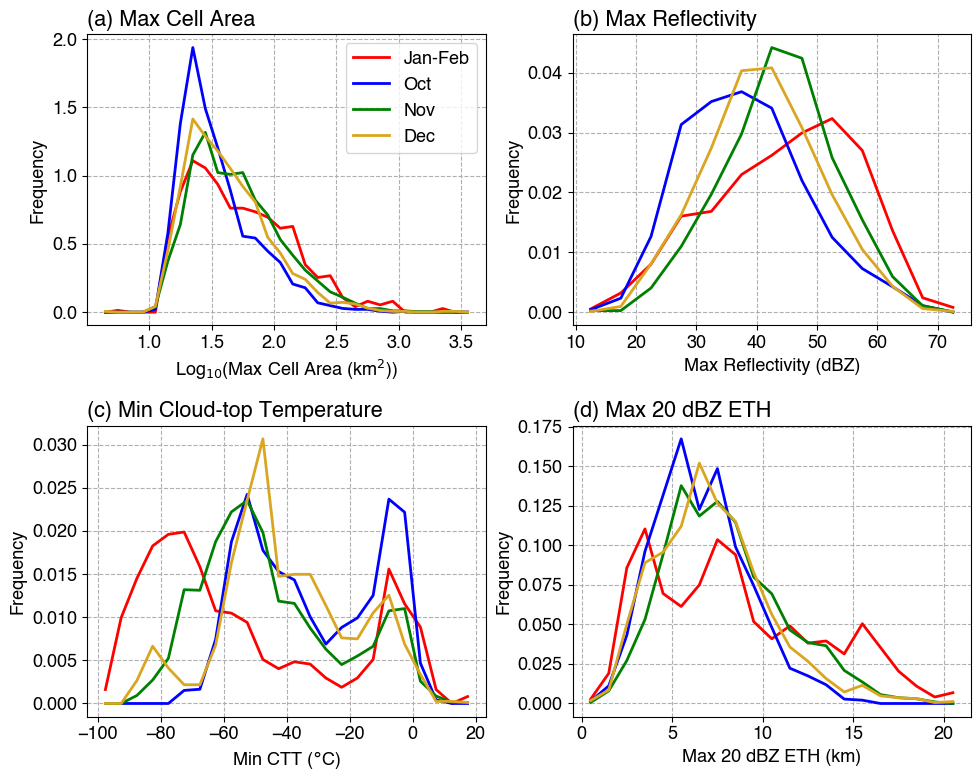

In [51]:
xbins = [[binv_cellarea, binv_maxdbz],
         [binv_minctt, binv_eth20]]
hist = [[pdf_cellareamax_month, pdf_maxdbz_month],
        [pdf_minctt_month, pdf_maxeth20_month]]
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Max Reflectivity (dBZ)'],
           ['Min CTT ($\degree$C)', 'Max 20 dBZ ETH (km)']]
titles = [['(a) Max Cell Area', '(b) Max Reflectivity'],
           ['(c) Min Cloud-top Temperature', '(d) Max 20 dBZ ETH']]
figname = f'{figdir}cellstats_pdf_bymonth.png'
fig = plot_2x2(xbins, hist, xlabels, titles, figname)

In [29]:
figname

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/cellstats_pdf_bymonth.png'

In [73]:
def plot_3x2(xbins, hist, xlabels, titles, figname):

    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(3, 2, figsize=(10, 10), dpi=100)
    
    month_names = {1:'Jan-Feb', 10:'Oct', 11:'Nov', 12:'Dec'}
    colors = {1:'r', 10:'b', 11:'g', 12:'goldenrod'}
    
    for row in range(3):
        for col in range(2):
            ax = axes[row, col]
            for ii in range(len(colors)):
                l1 = ax.plot(xbins[row][col], hist[row][col][ii,:], lw=2, 
                             color=colors[list(colors.keys())[ii]], label=list(month_names.values())[ii])
            ax.grid(ls='--')
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel('Frequency')
            ax.set_title(titles[row][col], loc='left')
            # ax.set_xticks(xticks[row][col])
            # ax.set_yticks(yticks[row][col])
            if (row == 0) & (col == 0):
                ax.legend()
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

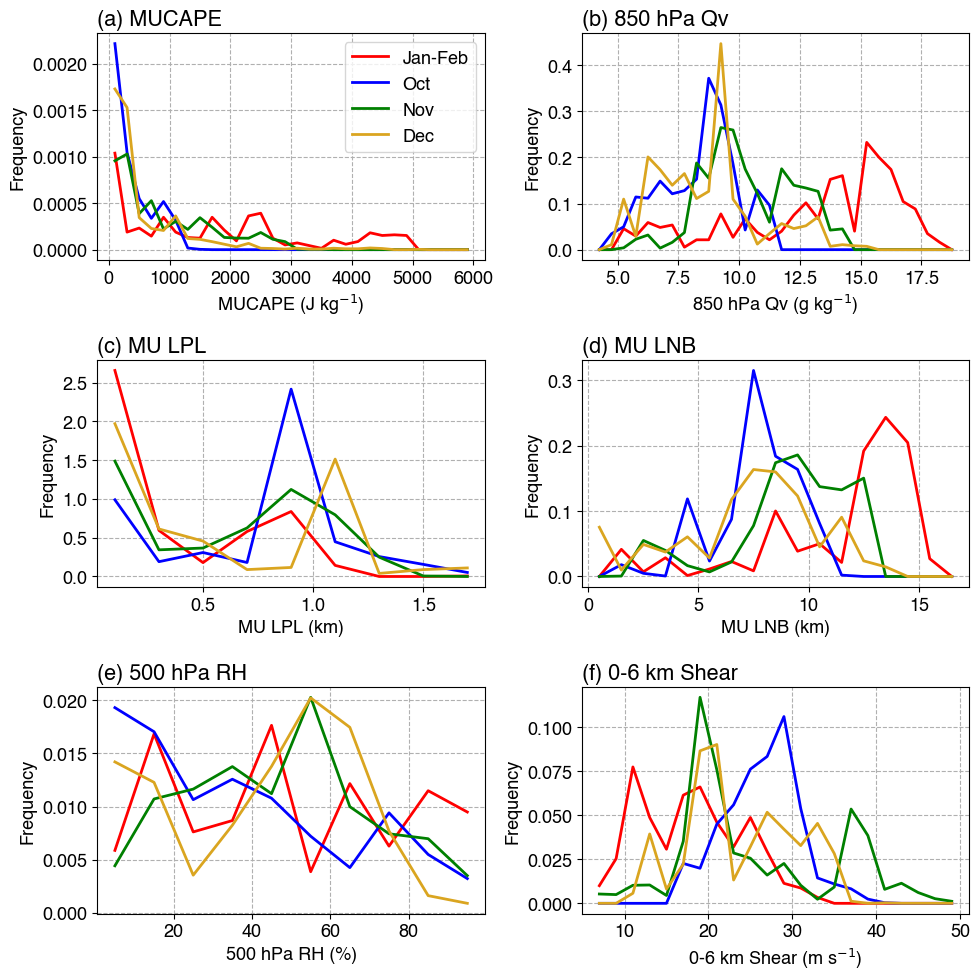

In [74]:
xbins = [[binv_cape, binv_q850p],
         [binv_lpl, binv_lnb],
         [binv_rh500p, binv_shear6mag]]
hist = [[pdf_cape_month, pdf_q850p_month],
        [pdf_lpl_month, pdf_lnb_month],
        [pdf_rh500p_month, pdf_shear6mag_month]]
xlabels = [['MUCAPE (J kg$^{-1}$)', '850 hPa Qv (g kg$^{-1}$)'],
           ['MU LPL (km)', 'MU LNB (km)'],
           ['500 hPa RH (%)', '0-6 km Shear (m s$^{-1}$)']]
titles = [['(a) MUCAPE', '(b) 850 hPa Qv'],
           ['(c) MU LPL', '(d) MU LNB'],
           ['(e) 500 hPa RH', '(f) 0-6 km Shear']]
figname = f'{figdir}cell_environments_pdf_bymonth.png'
fig = plot_3x2(xbins, hist, xlabels, titles, figname)

In [72]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'